Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

## Instructions
0. If you haven't already, follow [the setup instructions here](https://jennselby.github.io/MachineLearningCourseNotes/#setting-up-python3) to get all necessary software installed.
0. To be able to run the animation below, make sure you have the latest version of matplotlib, by running `python3 -m pip install matplotlib --upgrade`
0. Read through the code in the following sections:
    * [Define game environment and replay classes](#Define-game-environment-and-replay-classes)
    * [Define functions to create model, train, and visualize](#Define-functions-to-create-model,-train,-and-visualize)
    * [Try untrained model](#Try-untrained-model)
    * [Train and assess model](#Train-and-assess-model)
0. Complete some of the [Possible Exercises](#Possible-Exercises)

In [1]:
%matplotlib inline
import json
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

## Define game environment and replay classes
The idea in this FallingFruit game is that the user has to move to try to dodge the fruit. If they dodge it, they win and the game is over. If they get hit by it, they lose and the game is over. We are trying to teach the computer to play this game.

In [2]:
class FallingFruit(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 1
        self.max_player_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, player_center = self.state
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and player and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, player_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, player_center-1:player_center + 2] = 1  # draw 3-pixel player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was dodged, -1 if it hit, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, player_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - player_center) <= 1:
                return -1 # it was hit by fruit
            else:
                return 1 # it dodged the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([fruit_x, fruit_y, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




##  Define functions to create model, train, and visualize

In [3]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = FallingFruit(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = \
                take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = \
                take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Try untrained model

In [4]:
model, env, exp_replay = build_model()

Rewards in Animation: [1, -1, 1, 1, -1, 1, -1, 1, 1, 1]


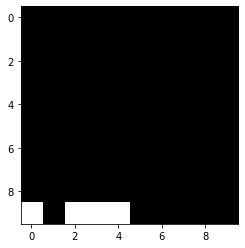

In [5]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

## Train and assess model

See how much better it is at dodging the fruit

starting
Episodes 0001-0010/0400 | Loss 0.0409 | Rewards [1, 1, 1, -1, 1, 1, 1, 1, 1, -1]
Episodes 0011-0020/0400 | Loss 0.0170 | Rewards [-1, 1, 1, -1, 1, 1, 1, 1, -1, -1]
Episodes 0021-0030/0400 | Loss 0.0174 | Rewards [1, 1, 1, 1, 1, 1, -1, -1, 1, 1]
Episodes 0031-0040/0400 | Loss 0.0214 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0041-0050/0400 | Loss 0.0134 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0051-0060/0400 | Loss 0.0178 | Rewards [1, 1, 1, 1, -1, 1, -1, -1, -1, 1]
Episodes 0061-0070/0400 | Loss 0.0532 | Rewards [-1, 1, 1, 1, 1, 1, 1, -1, -1, 1]
Episodes 0071-0080/0400 | Loss 0.0173 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]
Episodes 0081-0090/0400 | Loss 0.0335 | Rewards [1, 1, -1, -1, -1, 1, 1, 1, 1, 1]
Episodes 0091-0100/0400 | Loss 0.0028 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0101-0110/0400 | Loss 0.0047 | Rewards [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0111-0120/0400 | Loss 0.0249 | Rewards [1, 1, -1, 1, 1, -1, 1, 1, -1, 1]
Episodes 0121-0130/0

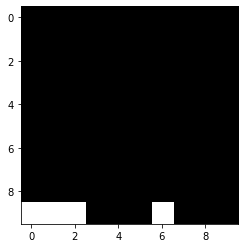

In [6]:
print("starting")
train_model(model, env, exp_replay, num_episodes=400)
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())
print("done")

In [7]:
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises
1. Standard Difficulty: Add a validation function, to make it easier to assess models.
1. Advanced Difficulty: We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Standard Difficulty: Change the code so that the player is trying to catch the fruit instead of dodging it.
1. Advanced Difficulty: Change the code so the episode keeps going until the player is hit by the fruit. (To test that this is working, you may want to change the number of episodes in the animation to 1.) How should this change the rewards that the model gets?
1. Advanced Difficulty: Change the game to something entirely different.
1. Standard Difficulty: Try changing how the training works (for instance, changing the discount rate or having the model always choose the action randomly weighted by the action values). Keep notes on what you observe as to how this changes the model performance.

In [70]:
from keras.layers.convolutional import Conv1D
from keras.layers import Flatten
agrid_size = 10

def build_cnn_model():
    '''
     Returns three initialized objects: the cnn model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(input_shape=(agrid_size**2), units=12, activation='tanh'))
#     model.add(Flatten())
    model.add(Conv1D(
#         input_shape=(10, agrid_size**1), 
                         filters=12, 
                         kernel_size=3, 
                         strides=2, 
                         padding='same'))
    model.add(Conv1D(
                         filters=12, 
                         kernel_size=3, 
                         strides=2, 
                         padding='same'))
#     model.add(Flatten())
    model.add(Dense(units=12, activation='tanh'))
    model.add(Dense(units=num_actions, activation='softmax'))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = FallingFruit(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

In [71]:
cnn_model, env, exp_replay = build_cnn_model()


TypeError: 'int' object is not iterable

In [72]:
train_model(cnn_model, env, exp_replay, num_episodes=50)

Consider rewriting this model with the Functional API.


TypeError: in user code:

    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:386 call
        outputs = layer(inputs, **kwargs)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:982 __call__
        self._maybe_build(inputs)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2643 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /usr/local/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1165 build
        input_shape = tensor_shape.TensorShape(input_shape)
    /usr/local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:756 __init__
        self._dims = [Dimension(d) for d in dims]
    /usr/local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:756 <listcomp>
        self._dims = [Dimension(d) for d in dims]
    /usr/local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:201 __init__
        six.raise_from(
    <string>:3 raise_from
        

    TypeError: Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([None, 144])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'


In [66]:
cnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 5, 12)             372       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 3, 12)             444       
_________________________________________________________________
dense_34 (Dense)             (None, 3, 12)             156       
_________________________________________________________________
dense_35 (Dense)             (None, 3, 3)              39        
Total params: 1,011
Trainable params: 1,011
Non-trainable params: 0
_________________________________________________________________
